<a href="https://colab.research.google.com/github/greo234/telediagnosiswithBERT/blob/main/BERT_4_med.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import transformers

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [42]:
filepath = 'https://raw.githubusercontent.com/greo234/telediagnosiswithBERT/main/text%20and%20symptoms_2.csv'

df = pd.read_csv(filepath)
df.drop(df.columns[0], axis=1, inplace=True)
df

,Patient_Problem,Disease
0,I have been experiencing a skin rash on my arm...,Psoriasis
1,"My skin has been peeling, especially on my kne...",Psoriasis
2,I have been experiencing joint pain in my fing...,Psoriasis
3,"There is a silver like dusting on my skin, esp...",Psoriasis
4,"My nails have small dents or pits in them, and...",Psoriasis
...,...,...
1195,I'm shaking and trembling all over. I've lost ...,diabetes
1196,"Particularly in the crevices of my skin, I hav...",diabetes
1197,I regularly experience these intense urges and...,diabetes
1198,"I have trouble breathing, especially outside. ...",diabetes


**EXPLORATORY DATA ANALYSIS**

Exploring how the dataset to draw insight as to give insight on what will be needed for the task.

In [43]:
df.head()

,Patient_Problem,Disease
0,I have been experiencing a skin rash on my arm...,Psoriasis
1,"My skin has been peeling, especially on my kne...",Psoriasis
2,I have been experiencing joint pain in my fing...,Psoriasis
3,"There is a silver like dusting on my skin, esp...",Psoriasis
4,"My nails have small dents or pits in them, and...",Psoriasis


In [44]:
df.isnull().sum()

Patient_Problem    0
Disease            0
dtype: int64

In [45]:
#disease count
disease_count = df['Disease'].value_counts()
disease_count

Disease
Psoriasis                          50
Varicose Veins                     50
peptic ulcer disease               50
drug reaction                      50
gastroesophageal reflux disease    50
allergy                            50
urinary tract infection            50
Malaria                            50
Jaundice                           50
Cervical spondylosis               50
Migraine                           50
Hypertension                       50
Bronchial Asthma                   50
Acne                               50
Arthritis                          50
Dimorphic Hemorrhoids              50
Pneumonia                          50
Common Cold                        50
Fungal infection                   50
Dengue                             50
Impetigo                           50
Chicken pox                        50
Typhoid                            50
diabetes                           50
Name: count, dtype: int64

<ipython-input-46-47a223818950>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


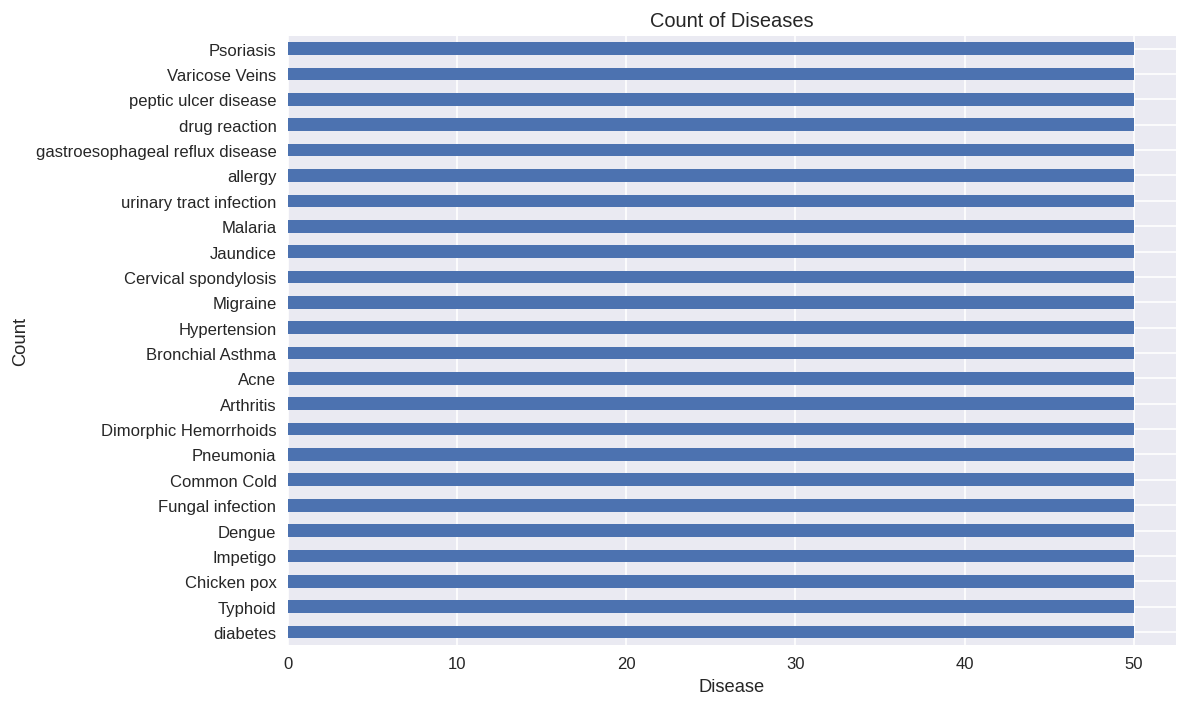

In [46]:
# Plot the disease count
plt.style.use('seaborn')
plt.figure(figsize=(10, 6), dpi=120)
disease_count.plot(kind='barh')
plt.title('Count of Diseases')
plt.xlabel('Disease')
plt.ylabel('Count')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [47]:
#Total Number of diseases
print('Total number of Diseases: %d'%(len(df['Disease'].value_counts().index)))

Total number of Diseases: 24


**PREPROCESSING FOR DIAGNOSTIC CLASSIFICATION**

In [74]:
import string
def remove_punctuation(text):
    # Create a translation table to remove punctuation characters
    translator = str.maketrans('', '', string.punctuation)
    # Remove punctuations from the text using translate()
    text = text.translate(translator)
    return text

# Apply the remove_punctuation function to the 'text' column and replace the original column
df['Patient_Problem'] = df['Patient_Problem'].apply(remove_punctuation)
med_data = df
med_data


,Patient_Problem,Disease
0,I have been experiencing a skin rash on my arm...,Psoriasis
1,My skin has been peeling especially on my knee...,Psoriasis
2,I have been experiencing joint pain in my fing...,Psoriasis
3,There is a silver like dusting on my skin espe...,Psoriasis
4,My nails have small dents or pits in them and ...,Psoriasis
...,...,...
1195,Im shaking and trembling all over Ive lost my ...,diabetes
1196,Particularly in the crevices of my skin I have...,diabetes
1197,I regularly experience these intense urges and...,diabetes
1198,I have trouble breathing especially outside I ...,diabetes


In [56]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into training and test sets for 'Patient_Problem' and 'Disease'
X, y_disease = med_data['Patient_Problem'], med_data['Disease']
X_train, problem_test, y_disease_train, disease_test = train_test_split(X, y_disease, test_size=0.15, random_state=4612)

# Further splitting the training set into training and validation sets
problem_train, problem_val, disease_train, disease_val = train_test_split(X_train, y_disease_train, test_size=0.15, random_state=4612)


In [57]:
print(f"samples in training set: {problem_train.shape[0]}\nsamples in validation set: {problem_val.shape[0]}\nsamples in test set: {problem_test.shape[0]}")


samples in training set: 765
samples in validation set: 255
samples in test set: 180


In [58]:
from transformers import BertTokenizer

# Initialize the BERT tokenizer with a pretrained model (e.g., 'bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

max_len = 0
input_ids = []

# For every problem...
for problem in problem_train:
    # Tokenize the problem and add special tokens--`[CLS]` and `[SEP]` tokens.
    tokens = tokenizer.encode(problem, add_special_tokens=True)
    input_ids.append(tokens)

    # Update the maximum sentence length.
    max_len = max(max_len, len(tokens))

# Calculate mean sentence length
mean_len = sum(len(tokens) for tokens in input_ids) / len(input_ids)

# Print the results
print('Max sentence length: %d \nMean sentence length: %d' % (max_len, mean_len))


Max sentence length: 63 
Mean sentence length: 36


In [59]:
def tokenize(problem):
  """
    Tokenize patient problems using the specified tokenizer.

    Returns:
    dict: Dictionary containing the tokenized inputs.
    """
  batch = tokenizer(list(problem),
                  padding=True,
                  truncation=True,
                  return_tensors="pt")
  return batch


In [60]:
token_train = tokenize(problem_train)
token_val = tokenize(problem_val)
token_test = tokenize(problem_test)

In [61]:
# Check the type and shape of the tokenized data
print(type(token_train))
print(len(token_train))

# Print the first few examples of the tokenized data
print(token_train[:5])

<class 'transformers.tokenization_utils_base.BatchEncoding'>
3
{'input_ids': tensor([[  101,  1045,  2064,  2102,  2644,  1055, 24045,  6774,  1998,  2026,
          4451,  2003,  2428,  2448,  4890, 10047,  2036,  2428,  3147,  1998,
          5458,  2035,  1996,  2051,  1998,  4921,  2063,  2042, 21454,  1037,
          2843,  2026,  9016,  2003,  2428,  2152,  2205,  2066,  2126,  2682,
          3671,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0],
        [  101,  2026, 23438,  2229,  5681,  3426,  2026,  3096,  2000,  2707,
          2000,  2991,  2125, 10047,  2062,  3497,  2000,  2131,  5665,  2004,
          1037,  2765,  2026,  2398,  5681,  2707,  2000, 20627,  1998,  1045,
          2707,  2000,  6073,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0, 

In [62]:
print("Input IDs:")
print(token_train['input_ids'][0])

# Print token type IDs for the first training example
print("Token Type IDs:")
print(token_train['token_type_ids'][0])

# Print attention mask for the first training example
print("Attention Mask:")
print(token_train['attention_mask'][0])

Input IDs:
tensor([  101,  1045,  2064,  2102,  2644,  1055, 24045,  6774,  1998,  2026,
         4451,  2003,  2428,  2448,  4890, 10047,  2036,  2428,  3147,  1998,
         5458,  2035,  1996,  2051,  1998,  4921,  2063,  2042, 21454,  1037,
         2843,  2026,  9016,  2003,  2428,  2152,  2205,  2066,  2126,  2682,
         3671,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0])
Token Type IDs:
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Attention Mask:
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [63]:
import tensorflow as tf
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


No GPU available, using the CPU instead.


In [64]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
label_train = torch.tensor((LE.fit_transform(disease_train)))
label_val = torch.tensor((LE.fit_transform(disease_val)))
label_test = torch.tensor((LE.fit_transform(disease_test)))

In [65]:
from torch.utils.data import TensorDataset

train_data = TensorDataset(token_train['input_ids'], token_train['attention_mask'],label_train)
val_data = TensorDataset(token_val['input_ids'], token_val['attention_mask'],label_val)
test_data = TensorDataset(token_test['input_ids'], token_test['attention_mask'],label_test)


In [66]:

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

# Create the DataLoaders for our training and validation sets.
train_dataloader = DataLoader(
            train_data,  # The training samples.
            sampler = RandomSampler(train_data), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation/test the order doesn't matter, so we'll just read them sequentially.
val_dataloader = DataLoader(
            val_data, # The validation samples.
            sampler = SequentialSampler(val_data), # Pull out batches sequentially.
            batch_size = 64 # Evaluate with this batch size.
        )

test_dataloader = DataLoader(
            val_data,
            sampler = SequentialSampler(val_data),
            batch_size = 64
        )


In [67]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

## use pretained base(relatively small) BERT mdoel for sequence classification
#CUDA_LAUNCH_BLOCKING=1
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 24)
#model.cuda() # make pytorch run this model on GPU.

## use AdamW optimizer
optimizer = AdamW(model.parameters(),
                  lr = 0.00002,
                  eps = 0.00000001)

from transformers import get_linear_schedule_with_warmup

# Total number of training steps is [number of batches] x [number of epochs].
total_steps = len(train_dataloader) * 4

## Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [68]:

# Function to calcuate the accuracy of the model

def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [69]:
import time
import datetime

def format_time(elapsed):
    #Takes a time in seconds and returns a string hh:mm:ss
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [70]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/Tensorboard')

In [71]:
# Start the training process:
import random
import torch

SEED = 1215
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
def train(epochs):
  total_t0 = time.time() # Measure the total training time for the whole run.
  tr_loss = 0
  n_correct = 0
  nb_tr_steps = 0
  nb_tr_examples = 0

  # For each epoch...
  for epoch in range(0, epochs):
      print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
      print('Training...')

      t0 = time.time()     # Measure how long the training epoch takes.
      total_tr_loss = 0
      total_n_correct = 0
      total_nb_tr_examples = 0
      model.train()    # Put the model into training mode

      # For each batch of training data...
      for step, batch in enumerate(train_dataloader, 0):
          # 'batch' contains three pytorch tensors:[0]: input ids, [1]: attention masks, [2]: labels
          input_ids = batch[0].to(device, dtype = torch.long)
          input_mask = batch[1].to(device, dtype = torch.long)
          labels = batch[2].to(device, dtype = torch.long)

          model.zero_grad()       #clear any previously calculated gradients

          outputs = model(input_ids, token_type_ids=None, attention_mask=input_mask)
          loss_function = torch.nn.CrossEntropyLoss()
          loss = loss_function(outputs[0], labels) #`loss` is a Tensor containing a single value
          tr_loss += loss.item() #.item()` function just returns the Python value from the tensor
          total_tr_loss += loss.item()
          big_val, big_idx = torch.max(outputs[0], dim=1)
          n_correct += calcuate_accu(big_idx, labels)
          total_n_correct += calcuate_accu(big_idx, labels)
          nb_tr_steps += 1
          nb_tr_examples+=labels.size(0)
          total_nb_tr_examples+=labels.size(0)

          if step % 20==19:
              loss_step = tr_loss/nb_tr_steps
              accu_step = n_correct/nb_tr_examples # #correct examples/all examples
              print(f"Training Loss per 20 steps(batches): {loss_step}")
              print(f"Training Accuracy per 20 steps(batches): {accu_step}")
              elapsed = format_time(time.time() - t0)    # Calculate elapsed time in minutes.
              # Report progress.
              print('Batch {} of {}.  Elapsed: {:}.'.format(step+1, len(train_dataloader), elapsed))
              #writer.add_scalar('training loss', loss_step, (epoch +1)*len(trainloader) )
              tr_loss = 0;n_correct = 0;nb_tr_steps = 0;nb_tr_examples = 0

          loss.backward() # Perform a backward pass to calculate the gradients.
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Clip the norm of the gradients to 1.0. This is to help prevent the "exploding gradients" problem.
          optimizer.step()
          scheduler.step() # Update the learning rate.

    # Calculate the average loss over all of the batches.
      train_loss_per_epoch = total_tr_loss / len(train_dataloader)
      train_accuracy_per_epoch=total_n_correct/total_nb_tr_examples
      # Measure how long this epoch took.
      training_time = format_time(time.time() - t0)

      print("")
      print("training loss per epoch: {0:.2f}".format(train_loss_per_epoch))
      print("training accuracy per epoch: {0:.2f}".format(train_accuracy_per_epoch))
      print("Training 1 epcoh took: {:}".format(training_time))


In [72]:
train(epochs = 5)

======== Epoch 1 / 5 ========
Training...
Training Loss per 20 steps(batches): 3.1050797939300536
Training Accuracy per 20 steps(batches): 0.090625
Batch 20 of 24.  Elapsed: 0:06:35.

training loss per epoch: 3.09
training accuracy per epoch: 0.10
Training 1 epcoh took: 0:08:09
======== Epoch 2 / 5 ========
Training...
Training Loss per 20 steps(batches): 2.9039452970027924
Training Accuracy per 20 steps(batches): 0.20261437908496732
Batch 20 of 24.  Elapsed: 0:06:32.

training loss per epoch: 2.86
training accuracy per epoch: 0.22
Training 1 epcoh took: 0:08:05
======== Epoch 3 / 5 ========
Training...
Training Loss per 20 steps(batches): 2.6962420841058097
Training Accuracy per 20 steps(batches): 0.31633986928104574
Batch 20 of 24.  Elapsed: 0:06:33.

training loss per epoch: 2.67
training accuracy per epoch: 0.33
Training 1 epcoh took: 0:08:06
======== Epoch 4 / 5 ========
Training...
Training Loss per 20 steps(batches): 2.5767649114131927
Training Accuracy per 20 steps(batches): 0.

In [72]:
# test the model on the validation set
def valid(model, val_loader):
  model.eval()
  val_loss = 0
  nb_val_examples = 0
  n_correct = 0
  with torch.no_grad():
    for _, data in enumerate(val_loader, 0):
      ids = data[0].to(device, dtype = torch.long)
      mask = data[1].to(device, dtype = torch.long)
      targets = data[2].to(device, dtype = torch.long)
      outputs = model(ids, mask)
      loss_function = torch.nn.CrossEntropyLoss()
      loss = loss_function(outputs[0], targets)
      val_loss += loss.item()
      big_val, big_idx = torch.max(outputs[0], dim=1)
      n_correct += calcuate_accu(big_idx, targets)
      nb_val_examples+=targets.size(0)

  val_ave_loss = val_loss/len(val_dataloader)
  val_accu = (n_correct*100)/nb_val_examples
  print("Loss on validation/test data: %0.2f" % val_ave_loss)
  print("Accuracy on validation/test data: %0.2f%%" % val_accu)

  return

In [73]:
valid(model, val_dataloader)

Loss on validation/test data: 2.72
Accuracy on validation/test data: 37.50%
